In [1]:
# импортируем некоторые питоновские модули
import os
import time

# импортируем необходимые библиотеки и функции
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# импортируем необходимые классы библиотеки lightautoml
from lightautoml.automl.presets.tabular_presets import (
    TabularAutoML,
    TabularUtilizedAutoML
)
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
# количество потоков
N_THREADS = 4
# количество блоков внутренного цикла 
# перекрестной проверки для AutoML
N_FOLDS = 5
# стартовое значение генератора
# псевдослучайных чисел
RANDOM_STATE = 42
# размер теста для оценки метрик
TEST_SIZE = 0.2
# время в секундах для выполнения AutoML
TIMEOUT = 300
# имя зависимой переменной
TARGET_NAME = 'TARGET'

In [3]:
# для лучшей воспроизводимости фиксируем стартовое 
# значение генератора псевдослучайных чисел 
# и максимальное количество потоков для Torch
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [4]:
# загружаем данные
data = pd.read_csv('Data/sampled_app_train.csv')
print(data.head())

   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      313802       0         Cash loans           M            N   
1      319656       0         Cash loans           F            N   
2      207678       0    Revolving loans           F            Y   
3      381593       0         Cash loans           F            N   
4      258153       0         Cash loans           F            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          270000.0    327024.0      15372.0   
1               N             0          108000.0    675000.0      19737.0   
2               Y             2          112500.0    270000.0      13500.0   
3               N             1           67500.0    142200.0       9630.0   
4               Y             0          337500.0   1483231.5      46570.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0             

In [5]:
# разбиваем данные на обучающую и тестовую выборки
train_data, test_data = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    stratify=data[TARGET_NAME], 
    random_state=RANDOM_STATE)
print("Разбиваем данные на части: обучающая = {}, тестовая = {}".format(
    train_data.shape, test_data.shape))

Разбиваем данные на части: обучающая = (8000, 122), тестовая = (2000, 122)


In [6]:
# задаем тип задачи, функцию потерь и метрику
task = Task(name='binary', loss='logloss', metric='auc')

In [7]:
# задаем роли переменных
roles = {'target': TARGET_NAME, 
         'drop': ['SK_ID_CURR']}

In [8]:
# создаем модель AutoML - экземпляр класса TabularAutoML
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 
                   'cv': N_FOLDS, 
                   'random_state': RANDOM_STATE}
)

In [9]:
%%time

# обучаем модель AutoML и получаем out-of-fold прогнозы
oof_pred = automl.fit_predict(train_data, roles=roles, verbose=1)

[12:53:16] Stdout logging level is INFO.
[12:53:16] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[12:53:16] Task: binary

[12:53:16] Start automl preset with listed constraints:
[12:53:16] - time: 300.00 seconds
[12:53:16] - CPU: 4 cores
[12:53:16] - memory: 16 GB

[12:53:16] Train data shape: (8000, 122)

[12:53:18] Layer 1 train process start. Time left 297.26 secs
[12:53:19] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:53:21] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7353552400153157
[12:53:21] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:53:21] Time left 294.56 secs

[12:53:23] Selector_LightGBM fitting and predicting completed
[12:53:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:53:35] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.735377350367659
[12:53:35] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:53:35] Start hyperparameters optimization for Lvl_0

In [10]:
# получаем прогнозы для тестовой выборки
test_pred = automl.predict(test_data)
print(f"Прогнозы для тестовой выборки:\n{test_pred}\n"
      f"Размерность = {test_pred.shape}")

Прогнозы для тестовой выборки:
array([[0.05416447],
       [0.06483244],
       [0.02746422],
       ...,
       [0.05342411],
       [0.03549265],
       [0.19597149]], dtype=float32)
Размерность = (2000, 1)


In [11]:
# получаем оценки AUC-ROC для обучающей выборки (используем 
# out-of-fold прогнозы) и тестовой выборки (используем
# прогнозы для тестовой выборки)
oof_auc = roc_auc_score(train_data[TARGET_NAME].values, 
                        oof_pred.data[:, 0])
holdout_auc = roc_auc_score(test_data[TARGET_NAME].values, 
                            test_pred.data[:, 0])
print(f"Оценка AUC-ROC oof: {oof_auc}") 
print(f"Оценка AUC-ROC holdout: {holdout_auc}")

Оценка AUC-ROC oof: 0.7528925762153412
Оценка AUC-ROC holdout: 0.7326630434782608


In [12]:
# выведем описание получившегося конвейера
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.19766 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.19802 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.18564 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.09663 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.32205 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [13]:
# создаем экземпляр класса ReportDeco
RD = ReportDeco(output_path='tabularAutoML_model_report')

# создаем модель AutoML - экземпляр класса TabularAutoML
automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 
                         'cv': N_FOLDS, 
                         'random_state': RANDOM_STATE} )
)

In [14]:
# обучаем модель AutoML, получаем out-of-fold прогнозы и генерируем отчет
oof_pred = automl_rd.fit_predict(train_data, roles=roles, verbose=0)

In [15]:
# выясним состав отчета
!ls tabularAutoML_model_report

feature_importance.png               valid_pr_curve.png
lama_interactive_report.html         valid_preds_distribution_by_bins.png
valid_distribution_of_logits.png     valid_roc_curve.png
valid_pie_f1_metric.png


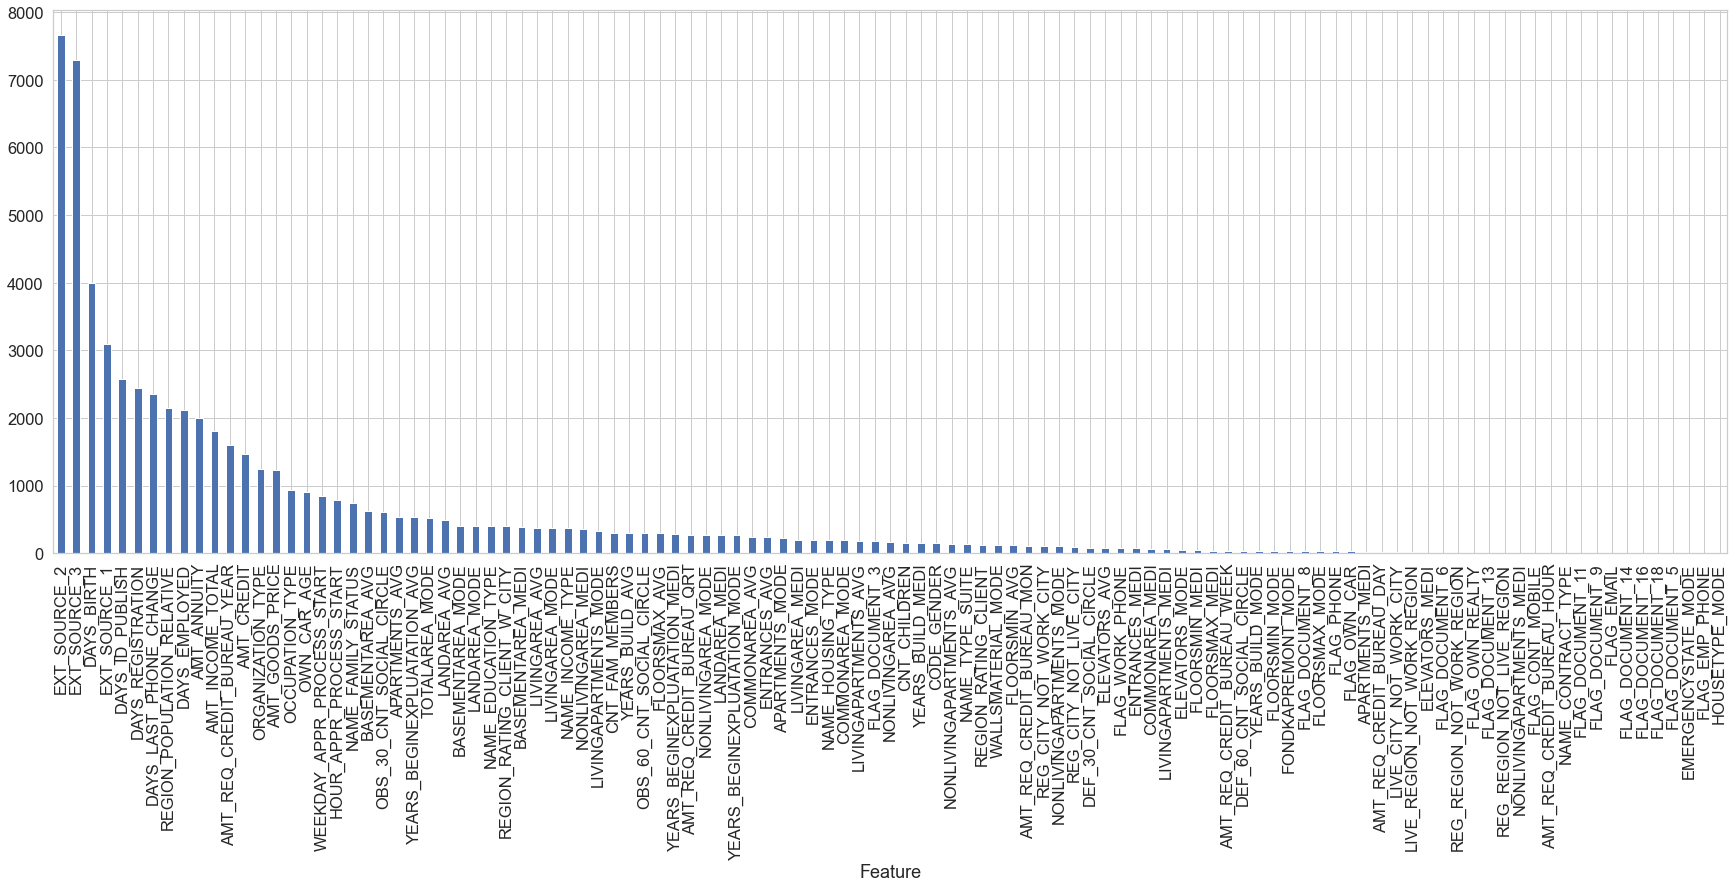

In [16]:
# вычисление быстрых важностей
fast_fi = automl_rd.model.get_feature_scores('fast') 
fast_fi.set_index('Feature')['Importance'].plot.bar(
    figsize=(30, 10), grid=True);

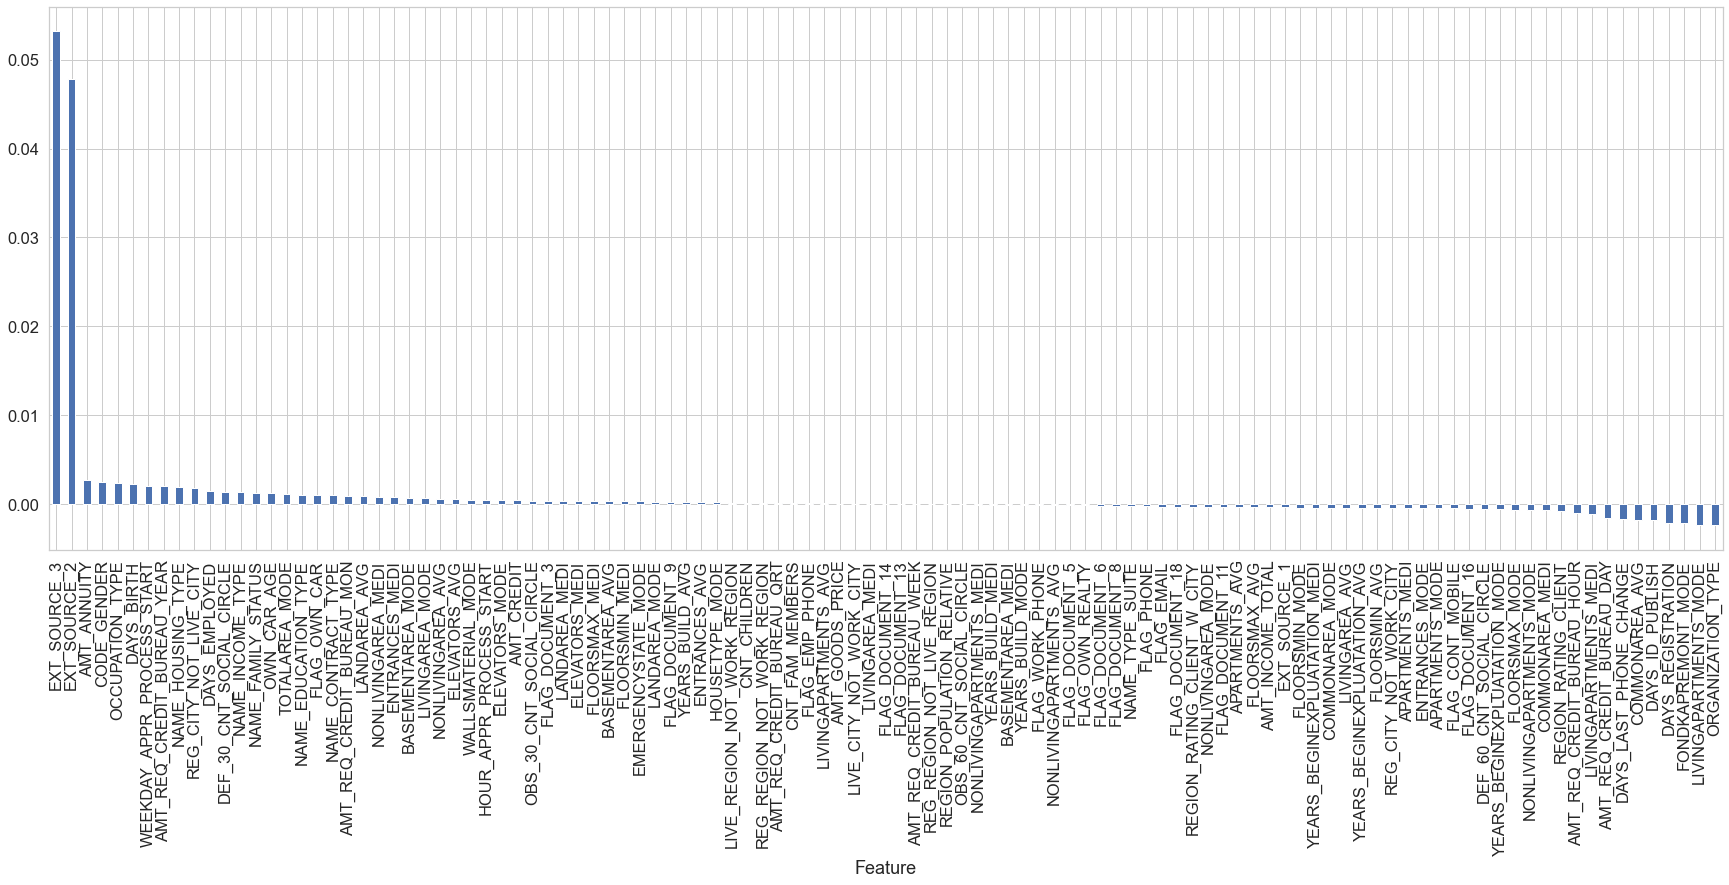

In [17]:
# вычисление точных важностей
accurate_fi = automl_rd.model.get_feature_scores(
    'accurate', test_data, silent=False)
accurate_fi.set_index('Feature')['Importance'].plot.bar(
    figsize=(30, 10), grid=True);

In [18]:
# строим модель AutoML с точной утилизацией времени
# и списком выбранных моделей
utilized_automl = TabularUtilizedAutoML(
    task=task,
    timeout=300,
    cpu_limit=N_THREADS,
    general_params={'nested_cv': False, 
                    'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
    reader_params={'n_jobs': N_THREADS, 
                   'cv': N_FOLDS, 
                   'random_state': RANDOM_STATE},
)

In [19]:
%%time

# обучаем модель AutoML и получаем out-of-fold прогнозы
oof_pred = utilized_automl.fit_predict(train_data, roles=roles, verbose=1)

[12:58:03] Start automl utilizator with listed constraints:
[12:58:03] - time: 300.00 seconds
[12:58:03] - CPU: 4 cores
[12:58:03] - memory: 16 GB

[12:58:03] If one preset completes earlier, next preset configuration will be started

[12:58:03] ==================================================
[12:58:03] Start 0 automl preset configuration:
[12:58:03] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[12:58:03] Stdout logging level is INFO.
[12:58:03] Task: binary

[12:58:03] Start automl preset with listed constraints:
[12:58:03] - time: 300.00 seconds
[12:58:03] - CPU: 4 cores
[12:58:03] - memory: 16 GB

[12:58:03] Train data shape: (8000, 122)

[12:58:03] Layer 1 train process start. Time left 299.28 secs
[12:58:04] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:58:06] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7353552400153157
[12:58:06] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicti

In [20]:
# получаем прогнозы для тестовой выборки
test_pred = utilized_automl.predict(test_data)
print(f"Прогнозы для тестовой выборки:\n{test_pred}\n"
      f"Размерность = {test_pred.shape}")

Прогнозы для тестовой выборки:
array([[0.08334242],
       [0.09848113],
       [0.03361353],
       ...,
       [0.05863738],
       [0.04168427],
       [0.20459233]], dtype=float32)
Размерность = (2000, 1)


In [21]:
# получаем оценки AUC-ROC для обучающей выборки (используем 
# out-of-fold прогнозы) и тестовой выборки (используем
# прогнозы для тестовой выборки)
oof_auc = roc_auc_score(train_data[TARGET_NAME].values, 
                        oof_pred.data[:, 0])
holdout_auc = roc_auc_score(test_data[TARGET_NAME].values, 
                            test_pred.data[:, 0])
print(f"Оценка AUC-ROC oof: {oof_auc}") 
print(f"Оценка AUC-ROC holdout: {holdout_auc}")

Оценка AUC-ROC oof: 0.7466908349825743
Оценка AUC-ROC holdout: 0.7331351902173913
